## Using the [`nnlm`](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) embeddings to classify IMDB reviews

The motivation behind this notebook comes from the this tutorial [Deep Transfer Learning for Natural Language Processing — Text Classification with Universal Embeddings](https://towardsdatascience.com/deep-transfer-learning-for-natural-language-processing-text-classification-with-universal-1a2c69e5baa9) written by [Diapnjan Sarkar](https://in.linkedin.com/in/dipanzan). Specifically from the following lines:

> Note: This tutorial is built using TensorFlow entirely given that they provide an easy access to the sentence encoders. However I’m not a big fan of their old APIs and I’m looking for someone to assist me on re-implementing the code using the tf.keras APIs instead of tf.estimator. Do reach out to me if you are interested in contributing and we can even feature your work on the same! (contact links in my profile and in the footer)

I am a newbie in NLP and I have always found Dipanjan's tutorial to be extremely informative and well-written. He not only shows you how to deal with a problem statement with the best set of tools but also discusses the corresponding literature in a very broad manner. It is been quite a while that I am exploring the newly released `tensorflow-2.0.0alpha0` (and I am kind of loving it). So, I decided to refactor Dipanjan's code to `tf.keras` as wanted by him. 

I had to use the CPU installation of `tensorflow-2.0.0alpha0` because the GPU installation is not stable yet to be compatible with [TensorFlow hub](https://tfhub.dev/google/tf2-preview) modules.

In the above-mentioned tutorial, Dipanjan presented a hands-on demo on the two very popular sentence embeddings - 
- [Universal Sentence Encoder](https://arxiv.org/abs/1803.11175)
- Neural-Net Language Models based on the seminal paper by Bengio et al. - [A Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

**This notebook uses the `nnlm` model.**

### Library imports

In [0]:
!pip install tensorflow==2.0.0-alpha0 
!pip install tensorflow-hub
!pip install contractions
!pip install beautifulsoup4

In [0]:
import tensorflow as tf
import tensorflow_hub as tf_hub
import pandas as pd
import numpy as np

In [3]:
tf.test.is_gpu_available()

False

### Data loading and previewing

In [4]:
url = 'https://github.com/dipanjanS/data_science_for_all/blob/master/tds_deep_transfer_learning_nlp_classification/movie_reviews.csv.bz2?raw=true'
dataset = pd.read_csv(url, compression='bz2')
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


### Numericalization of the sentiments to ease the computations

In [5]:
dataset['sentiment'] = dataset.sentiment.map({"positive": 1, "negative": 0})
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Data splits

In [6]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:30000]
train_sentiments = sentiments[:30000]

val_reviews = reviews[30000:35000]
val_sentiments = sentiments[30000:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((30000,), (5000,), (15000,))

### Little helper functions to preprocess the reviews

These functions are all written by Dipanjan and I have copy-pasted them (yes, no shame). 

In [0]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions    
    document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [0]:
train_reviews = pre_process_corpus(train_reviews)
val_reviews = pre_process_corpus(val_reviews)
test_reviews = pre_process_corpus(test_reviews)

### Preparing `numpy` arrays of the reviews and the labels

In [0]:
X_train = np.asarray(train_reviews)
X_valid = np.asarray(val_reviews)

y_train = np.array(train_sentiments)
y_valid = np.array(val_sentiments)

### Get the embedding model from TensorFlow hub and see a few embeddings 

**Caution**: 128D ahead.

In [0]:
model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = tf_hub.KerasLayer(model, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_reviews[:3])

### Constructing a sequential `keras` model

The architecture I used is a bit different from the one Dipanjan used. 

In [11]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


The model does not contain any **Dropout** layers. 

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        epochs=12, batch_size=256)

Train on 30000 samples, validate on 5000 samples
Epoch 1/12
30000/30000 [==============================] - 177s 6ms/sample - loss: 0.4459 - accuracy: 0.8132 - val_loss: 0.2909 - val_accuracy: 0.8766
Epoch 2/12
30000/30000 [==============================] - 174s 6ms/sample - loss: 0.2084 - accuracy: 0.9224 - val_loss: 0.2641 - val_accuracy: 0.8908
Epoch 3/12
30000/30000 [==============================] - 173s 6ms/sample - loss: 0.1298 - accuracy: 0.9566 - val_loss: 0.2630 - val_accuracy: 0.8964
Epoch 4/12
30000/30000 [==============================] - 172s 6ms/sample - loss: 0.0808 - accuracy: 0.9766 - val_loss: 0.2967 - val_accuracy: 0.8910
Epoch 5/12
30000/30000 [==============================] - 174s 6ms/sample - loss: 0.0485 - accuracy: 0.9884 - val_loss: 0.3345 - val_accuracy: 0.8898
Epoch 6/12
30000/30000 [==============================] - 172s 6ms/sample - loss: 0.0283 - accuracy: 0.9950 - val_loss: 0.3734 - val_accuracy: 0.8878
Epoch 7/12
30000/30000 [===========================

Absence of the **Dropout** layers is quite evident. The mode clearly overfits. 

### Performance visualization of the baseline model (fine-tuned, though)

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

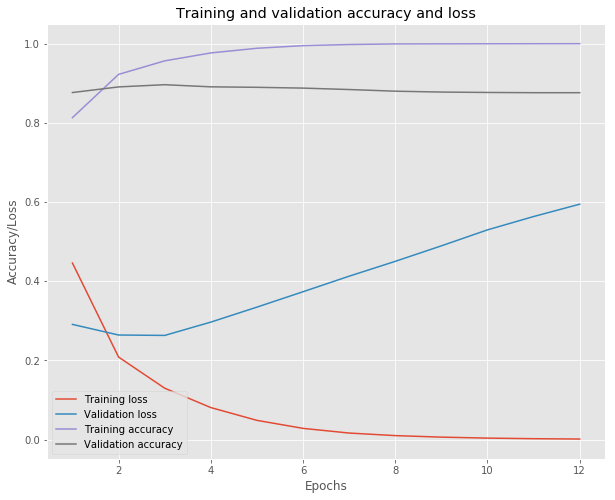

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')

plt.title('Training and validation accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()

### Accuracy on the test set

In [18]:
model.evaluate(np.array(test_reviews), np.array(test_sentiments))

15000/15000 [==============================] - 82s 5ms/sample - loss: 0.5725 - accuracy: 0.8793


[0.572544362214456, 0.8793333]

### Classification report

In [21]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(np.array(test_reviews))

print(classification_report(np.array(test_sentiments), y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      7490
           1       0.87      0.89      0.88      7510

   micro avg       0.88      0.88      0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



### Initial model + Dropout layers + EarlyStopping

In [24]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        epochs=12, batch_size=256, callbacks=[es_cb])

Train on 30000 samples, validate on 5000 samples
Epoch 1/12
30000/30000 [==============================] - 171s 6ms/sample - loss: 0.1887 - accuracy: 0.9472 - val_loss: 0.3106 - val_accuracy: 0.8850
Epoch 2/12
30000/30000 [==============================] - 171s 6ms/sample - loss: 0.0354 - accuracy: 0.9955 - val_loss: 0.3925 - val_accuracy: 0.8820
Epoch 3/12
30000/30000 [==============================] - 171s 6ms/sample - loss: 0.0177 - accuracy: 0.9981 - val_loss: 0.4588 - val_accuracy: 0.8802
Epoch 4/12
30000/30000 [==============================] - 171s 6ms/sample - loss: 0.0101 - accuracy: 0.9993 - val_loss: 0.5355 - val_accuracy: 0.8786
Epoch 5/12
30000/30000 [==============================] - 171s 6ms/sample - loss: 0.0071 - accuracy: 0.9992 - val_loss: 0.5745 - val_accuracy: 0.8774
Epoch 6/12
30000/30000 [==============================] - 171s 6ms/sample - loss: 0.0052 - accuracy: 0.9997 - val_loss: 0.6162 - val_accuracy: 0.8782


The model still overfits. More sophisticated parameter initialization would be helpful. 

### Performance visualization of Model-2

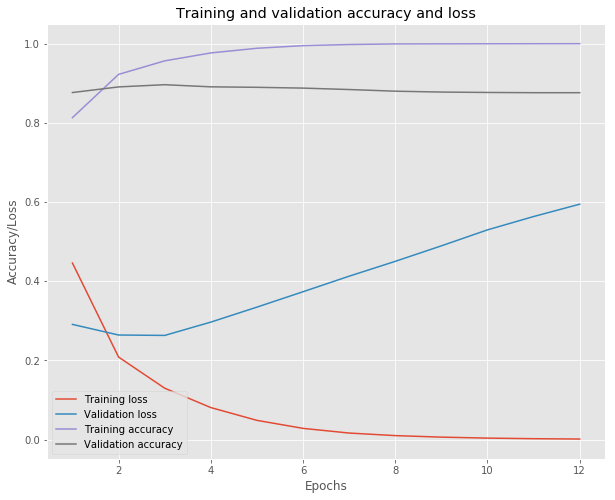

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')

plt.title('Training and validation accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()

### Accuracy has increased a bit, although

In [29]:
model.evaluate(np.array(test_reviews), np.array(test_sentiments))

15000/15000 [==============================] - 81s 5ms/sample - loss: 0.5889 - accuracy: 0.8803


[0.5888620198649664, 0.8803333]

### Classification report of Model-2

In [30]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(np.array(test_reviews))

print(classification_report(np.array(test_sentiments), y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7490
           1       0.88      0.88      0.88      7510

   micro avg       0.88      0.88      0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



Here are the details of the model' evaluation which is taken from the original tutorial: 

![](https://cdn-images-1.medium.com/max/1200/1*MMpvIAOh0Ac3-0GKAhV_gw.png)

The results are more or less very similar (yes, I did not print the AUC score). 